In [238]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [239]:
def gen_data(rows, cols):
    np.random.seed(10)
    X = np.random.randn(rows, cols)

    t_coff = np.random.randn(cols)
    t_coff[2:5] = 0

    noise = np.random.randn(rows) * 0.4
    y = np.dot(X, t_coff) + noise

    df = pd.DataFrame(X, columns = [f'feature_{i+1}' for i in range(cols)])
    df['target'] = y
    
    x = df.drop("target", axis = 1)
    Y   = df["target"]
    
    return x, Y

In [240]:
def linear_data_generator(m,N,b,rnge =[-10,10], scale = 1, random_seed = 8675309 ):
        rng = np.random.default_rng(seed=random_seed)
        sample = rng.uniform(low=rnge[0], high=rnge[1], size=(N, len(m)))
        m_reshaped = np.array(m).reshape(-1,1)
        ys = np.dot(sample, m_reshaped) + b
        noise = rng.normal(loc=0., scale=scale, size=ys.shape)
        return sample, (ys + noise).flatten()

In [241]:
def train_test_split(x, y, test_size): 
    np.random.seed(10)
    
    rows = x.shape[0]
    test = int(rows * test_size)
    test_index = np.random.choice(rows,test, replace= False)
    
    dublicate = np.zeros(rows, dtype=bool)
    dublicate[test_index] = True

    if isinstance(x, pd.DataFrame):
        X_train = x[~dublicate].reset_index(drop=True)
        X_test = x[dublicate].reset_index(drop=True)
    else:
        X_train = x[~dublicate]
        X_test = x[dublicate]
    
    if isinstance(y, pd.Series):
        y_train = y[~dublicate].reset_index(drop=True)
        y_test = y[dublicate].reset_index(drop=True)
    else:
        y_train = y[~dublicate]
        y_test = y[dublicate]
    
    return X_train, X_test, y_train, y_test

In [242]:
class ElasticNetModel: 
    def __init__(self,
                 alpha =0.01,
                 penalty_ratio = 0.1,
                 learning_rate = 0.001,
                 iterations = 150000):
        
        self.alpha = alpha
        self.penalty_ratio = penalty_ratio
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = 0 
        
    def linear_reg_model(self, x_test): 
        return np.dot(x_test, self.weights) + self.bias
    
    def l1_penalty(self):
        return self.penalty_ratio * np.sign(self.weights)
    
    def l2_penalty(self):
        return (1 - self.penalty_ratio) * self.weights
    

    
    def ourfit(self, X_train, y_train):
        
        if isinstance(X_train, (pd.DataFrame, pd.Series)):
            X_train = X_train.to_numpy()
        if isinstance(y_train, (pd.DataFrame, pd.Series)):
            y_train = y_train.to_numpy()
        
        rows, cols = X_train.shape
        # self.weights = np.zeros(cols)   
        
        # if y_train.ndim > 1:
        #     y_train = y_train.flatten()
        
        self.weights = np.zeros(cols)
        
        for i in range(self.iterations):
            y_pred = self.linear_reg_model(X_train)
            residuals = y_pred - y_train
            
            # print(residuals)
            
            gradients_w = (1 / rows) * np.dot(X_train.T, residuals)
            gradients_b = (1 / rows) * np.sum(residuals)
            
            # print(gradients_w,gradients_b)
            
            self.weights -= self.learning_rate * (gradients_w + self.alpha * (self.l1_penalty() + self.l2_penalty()))
            self.bias -= self.learning_rate * gradients_b
            
            if i % 1000 == 0:
                loss = (1 / rows) * np.sum((y_train - y_pred) ** 2) 
                # print(f"Iteration {i}, Loss: {loss}")
  
    def predict(self, X_test):
        if isinstance(X_test, (pd.DataFrame, pd.Series)):
            X_test = X_test.to_numpy()
        return self.linear_reg_model(X_test)
    
    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2 

In [243]:
def standardize(X_train, X_test):
    mean = X_train.mean()
    std = X_train.std()
    X_train_std = (X_train - mean)/std
    X_test_std = (X_test - mean)/std
    return X_train_std, X_test_std

## Waves 35 DataSet using Our Elastic Net Model 

In [244]:
waves35_df = pd.read_csv("DATASET/35.waves (1).csv")

waves35_X = waves35_df.drop("WVHT", axis=1)
waves35_y = waves35_df['WVHT']

waves35_X.shape, waves35_y.shape

((3886, 11), (3886,))

In [245]:
waves35_y.dtype

dtype('float64')

In [246]:
waves35_X_train, waves35_X_test, waves35_y_train, waves35_y_test = train_test_split(waves35_X,waves35_y, test_size=0.2)

waves35_X_train.shape, waves35_X_test.shape, waves35_y_train.shape, waves35_y_test.shape

((3109, 11), (777, 11), (3109,), (777,))

In [247]:
waves35_X_train_std, waves35_X_test_std = standardize(waves35_X_train, waves35_X_test)

waves35_X_train_std.shape, waves35_X_test_std.shape

((3109, 11), (777, 11))

In [248]:
waves35_model = ElasticNetModel(alpha = 0.01,
                   penalty_ratio = 0.5,
                   learning_rate =0.001,
                   iterations= 10000)

waves35_model.ourfit(waves35_X_train_std.values, waves35_y_train.values)

from sklearn.linear_model import ElasticNet
waves35_SkModel = ElasticNet(alpha =0.01,
                             l1_ratio= 0.5,
                             max_iter=10000)
waves35_SkModel.fit(waves35_X_train_std.values, waves35_y_train.values)


ElasticNet(alpha=0.01, max_iter=10000)

In [249]:
waves35_y_pred =  waves35_model.predict(waves35_X_test_std.values)
Skwaves35_y_pred =  waves35_SkModel.predict(waves35_X_test_std.values)

In [250]:
# print("Learned Weights:", model.weights)
# print("Learned Bias:", model.bias)

comparison_df = pd.DataFrame({
    'Actual Values': waves35_y_test.values,
    'Predicted Values': waves35_y_pred
})

Skcomparison_df = pd.DataFrame({
    'Actual Values': waves35_y_test.values,
    'Predicted Values': Skwaves35_y_pred
})


Skcomparison_df.head(20)

,Actual Values,Predicted Values
0,0.65,0.743745
1,0.69,1.021017
2,0.42,0.449760
3,0.42,0.458279
4,0.27,0.292781
5,0.36,0.372839
6,0.41,0.425952
7,0.43,0.412075
8,0.26,0.271803
9,0.38,0.391694


In [251]:
comparison_df["difference"] = comparison_df['Actual Values'] - comparison_df['Predicted Values']
Skcomparison_df["difference"] = Skcomparison_df['Actual Values'] - Skcomparison_df['Predicted Values']


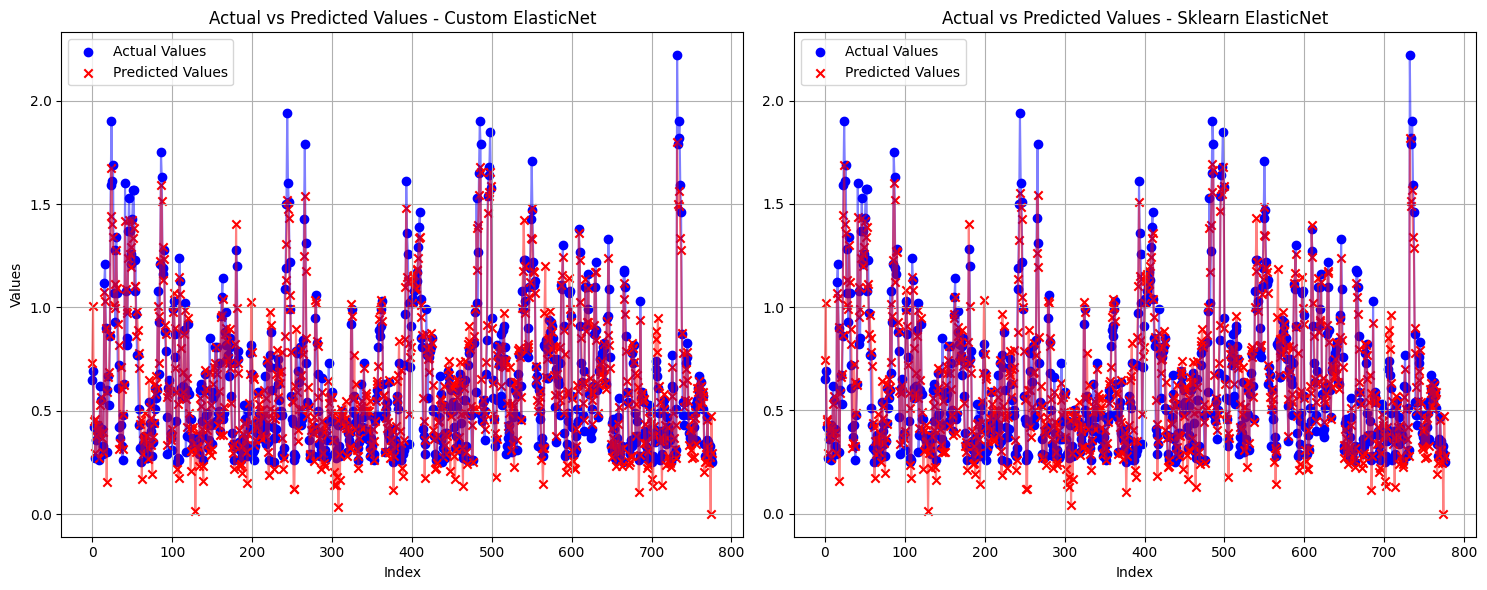

Custom Model MSE: 0.013472833478519956
Custom Model MAE: 0.0861923004474587
Custom Model R² Score: 0.89264285815581

Sklearn Model MSE: 0.013068736189031592
Sklearn Model MAE: 0.08485319279553154
Sklearn Model R² Score: 0.8958628734625843



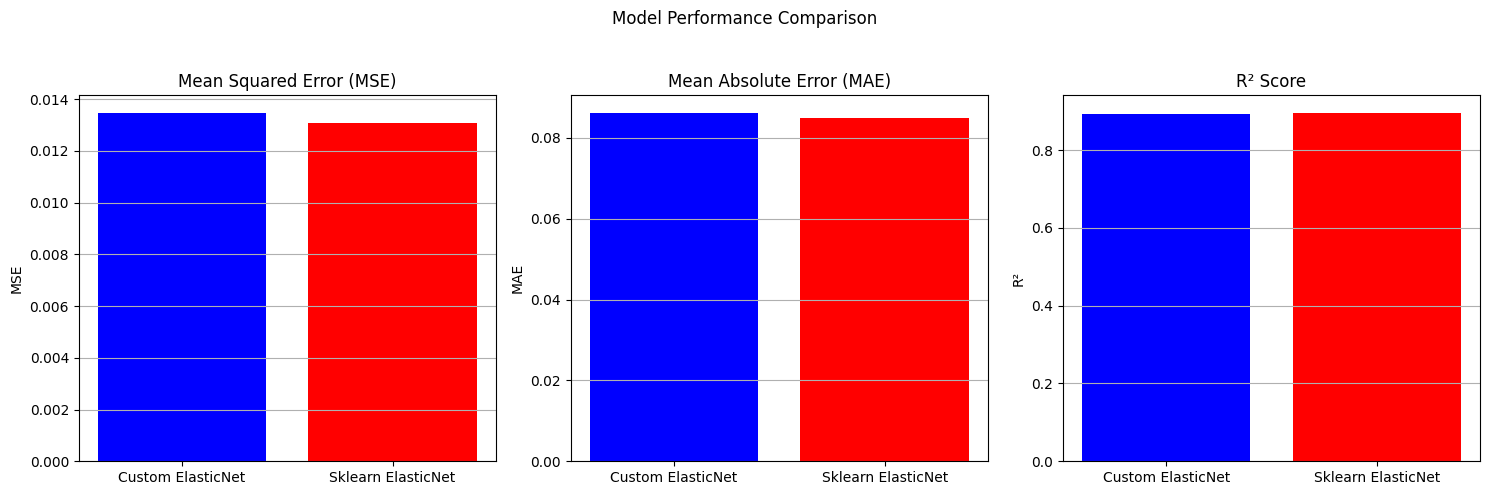

In [252]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(comparison_df.index, comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[0].scatter(comparison_df.index, comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[0].plot(comparison_df.index, comparison_df['Actual Values'], color='blue', alpha=0.5)
axs[0].plot(comparison_df.index, comparison_df['Predicted Values'], color='red', alpha=0.5)
axs[0].set_title('Actual vs Predicted Values - Custom ElasticNet')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid()

axs[1].scatter(Skcomparison_df.index, Skcomparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[1].scatter(Skcomparison_df.index, Skcomparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[1].plot(Skcomparison_df.index, Skcomparison_df['Actual Values'], color='blue', alpha=0.5)
axs[1].plot(Skcomparison_df.index, Skcomparison_df['Predicted Values'], color='red', alpha=0.5)
axs[1].set_title('Actual vs Predicted Values - Sklearn ElasticNet')
axs[1].set_xlabel('Index')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

custom_mse = np.square(comparison_df["difference"]).mean()
custom_mae = np.abs(comparison_df['difference']).mean()
custom_r2 = waves35_model.r2_score(waves35_y_test.values, waves35_y_pred)

sklearn_mse = np.square(Skcomparison_df["difference"]).mean()
sklearn_mae = np.abs(Skcomparison_df['difference']).mean()
sklearn_r2 = waves35_model.r2_score(waves35_y_test.values, Skwaves35_y_pred)

print(f"Custom Model MSE: {custom_mse}")
print(f"Custom Model MAE: {custom_mae}")
print(f"Custom Model R² Score: {custom_r2}\n")

print(f"Sklearn Model MSE: {sklearn_mse}")
print(f"Sklearn Model MAE: {sklearn_mae}")
print(f"Sklearn Model R² Score: {sklearn_r2}\n")

custom_values = [custom_mse, custom_mae, custom_r2]
sklearn_values = [sklearn_mse, sklearn_mae, sklearn_r2]
metric_labels = ['MSE', 'MAE', 'R²']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mse, sklearn_mse], color=['blue', 'red'])
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_ylabel('MSE')
axs[0].grid(axis='y')
axs[1].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mae, sklearn_mae], color=['blue', 'red'])
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_ylabel('MAE')
axs[1].grid(axis='y')

axs[2].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_r2, sklearn_r2], color=['blue', 'red'])
axs[2].set_title('R² Score')
axs[2].set_ylabel('R²')
axs[2].grid(axis='y')

fig.suptitle('Model Performance Comparison')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Heart Disease DataSet Using Our ElasticNet Model

In [253]:
Heart_Disease_df = pd.read_csv("DATASET/heart-disease.csv")

hd_X = Heart_Disease_df.drop("target", axis=1)
hd_y = Heart_Disease_df['target']

hd_X.shape, hd_y.shape

((303, 13), (303,))

In [254]:
hd_X_train, hd_X_test, hd_y_train, hd_y_test = train_test_split(hd_X,hd_y, test_size=0.2)

hd_X_train.shape, hd_X_test.shape, hd_y_train.shape, hd_y_test.shape

((243, 13), (60, 13), (243,), (60,))

In [255]:
hd_X_train_std, hd_X_test_std = standardize(hd_X_train, hd_X_test)

hd_X_train_std.shape, hd_X_test_std.shape

((243, 13), (60, 13))

In [256]:
hd_model = ElasticNetModel(alpha = 0.01,
                   penalty_ratio = 0.1,
                   learning_rate =0.001,
                   iterations= 10000)

hd_model.ourfit(hd_X_train_std.values, hd_y_train.values)

hd_SkModel = ElasticNet(alpha =0.01,
                             l1_ratio= 0.5,
                             max_iter=10000)
hd_SkModel.fit(hd_X_train_std.values, hd_y_train.values)

ElasticNet(alpha=0.01, max_iter=10000)

In [257]:
hd_y_pred =  hd_model.predict(hd_X_test_std.values)
Skhd_y_pred =  hd_model.predict(hd_X_test_std.values)

In [258]:
hd_comparison_df = pd.DataFrame({
    'Actual Values': hd_y_test.values,
    'Predicted Values': hd_y_pred
})

Skhd_comparison_df = pd.DataFrame({
    'Actual Values': hd_y_test.values,
    'Predicted Values': Skhd_y_pred
})

hd_comparison_df["difference"] = hd_comparison_df['Actual Values'] - hd_comparison_df['Predicted Values']
Skhd_comparison_df["difference"] = Skhd_comparison_df['Actual Values'] - Skhd_comparison_df['Predicted Values']


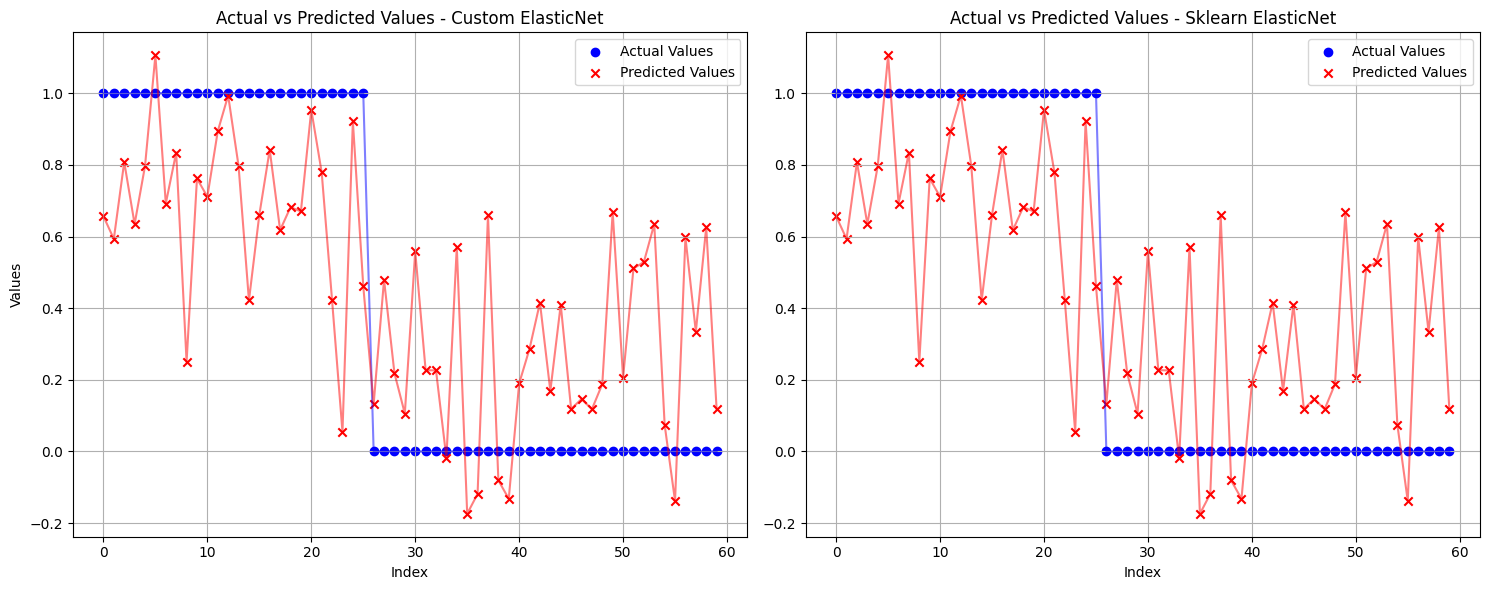

Custom Model MSE: 0.1373647760018273
Custom Model MAE: 0.30626278692552433
Custom Model R² Score: 0.89264285815581

Sklearn Model MSE: 0.1373647760018273
Sklearn Model MAE: 0.30626278692552433
Sklearn Model R² Score: 0.8958628734625843



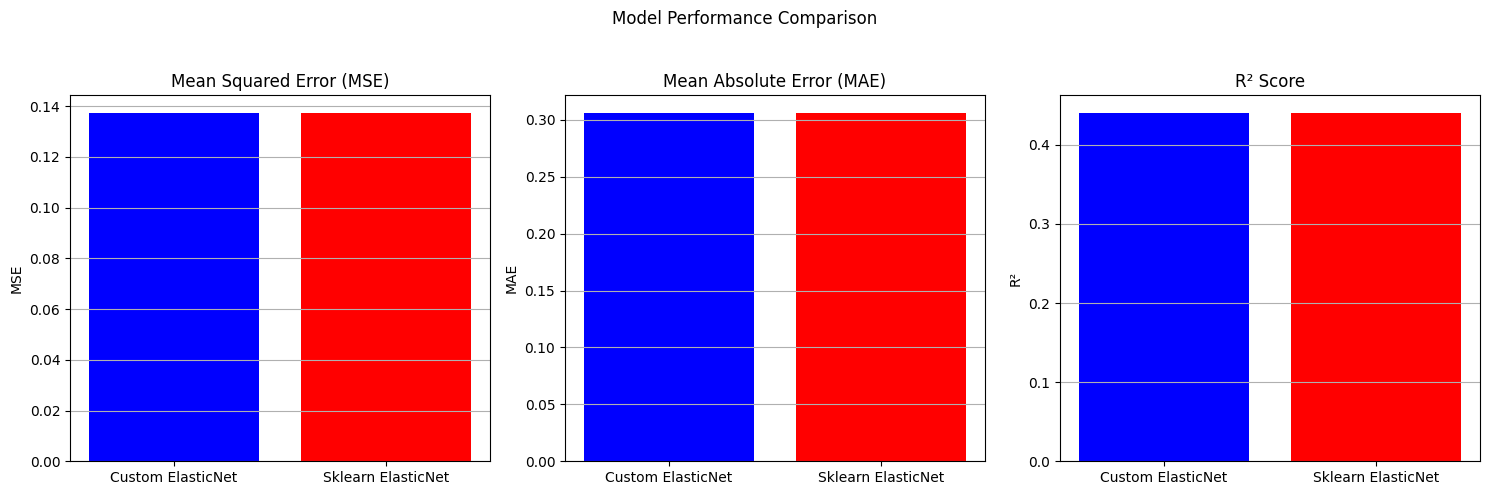

In [259]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(hd_comparison_df.index, hd_comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[0].scatter(hd_comparison_df.index, hd_comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[0].plot(hd_comparison_df.index, hd_comparison_df['Actual Values'], color='blue', alpha=0.5)
axs[0].plot(hd_comparison_df.index, hd_comparison_df['Predicted Values'], color='red', alpha=0.5)
axs[0].set_title('Actual vs Predicted Values - Custom ElasticNet')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid()

axs[1].scatter(Skhd_comparison_df.index, Skhd_comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[1].scatter(Skhd_comparison_df.index, Skhd_comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[1].plot(Skhd_comparison_df.index, Skhd_comparison_df['Actual Values'], color='blue', alpha=0.5)
axs[1].plot(Skhd_comparison_df.index, Skhd_comparison_df['Predicted Values'], color='red', alpha=0.5)
axs[1].set_title('Actual vs Predicted Values - Sklearn ElasticNet')
axs[1].set_xlabel('Index')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

custom_mse = np.square(hd_comparison_df["difference"]).mean()
custom_mae = np.abs(hd_comparison_df['difference']).mean()
custom_r2 = waves35_model.r2_score(waves35_y_test.values, waves35_y_pred)

sklearn_mse = np.square(Skhd_comparison_df["difference"]).mean()
sklearn_mae = np.abs(Skhd_comparison_df['difference']).mean()
sklearn_r2 = waves35_model.r2_score(waves35_y_test.values, Skwaves35_y_pred)

print(f"Custom Model MSE: {custom_mse}")
print(f"Custom Model MAE: {custom_mae}")
print(f"Custom Model R² Score: {custom_r2}\n")

print(f"Sklearn Model MSE: {sklearn_mse}")
print(f"Sklearn Model MAE: {sklearn_mae}")
print(f"Sklearn Model R² Score: {sklearn_r2}\n")

custom_values = [custom_mse, custom_mae, custom_r2]
sklearn_values = [sklearn_mse, sklearn_mae, sklearn_r2]
metric_labels = ['MSE', 'MAE', 'R²']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mse, sklearn_mse], color=['blue', 'red'])
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_ylabel('MSE')
axs[0].grid(axis='y')

axs[1].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mae, sklearn_mae], color=['blue', 'red'])
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_ylabel('MAE')
axs[1].grid(axis='y')

axs[2].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_r2, sklearn_r2], color=['blue', 'red'])
axs[2].set_title('R² Score')
axs[2].set_ylabel('R²')
axs[2].grid(axis='y')

fig.suptitle('Model Performance Comparison')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Using Generated Data for Our Model

In [260]:
gen_X, gen_y = gen_data(1000,10)

gen_X.shape, gen_y.shape

((1000, 10), (1000,))

In [261]:
gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X,gen_y, test_size=0.2)

gen_X_train.shape, gen_X_test.shape, gen_y_train.shape, gen_y_test.shape

((800, 10), (200, 10), (800,), (200,))

In [262]:
gen_X_train_std, gen_X_test_std = standardize(gen_X_train, gen_X_test)

gen_X_train_std.shape, gen_X_test_std.shape

((800, 10), (200, 10))

In [263]:
gen_model = ElasticNetModel(alpha = 0.01,
                   penalty_ratio = 0.1,
                   learning_rate =0.001,
                   iterations= 10000)

gen_model.ourfit(gen_X_train_std.values, gen_y_train.values)

gen_SkModel = ElasticNet(alpha =0.01,
                             l1_ratio= 0.5,
                             max_iter=10000)
gen_SkModel.fit(gen_X_train_std.values, gen_y_train.values)

ElasticNet(alpha=0.01, max_iter=10000)

In [264]:
gen_y_pred =  gen_model.predict(gen_X_test_std.values)
Skgen_y_pred =  gen_SkModel.predict(gen_X_test_std.values)

In [265]:
gen_comparison_df = pd.DataFrame({
    'Actual Values': gen_y_test.values,
    'Predicted Values': gen_y_pred
})

Skgen_comparison_df = pd.DataFrame({
    'Actual Values': gen_y_test.values,
    'Predicted Values': Skgen_y_pred
})

gen_comparison_df["difference"] = gen_comparison_df['Actual Values'] - gen_comparison_df['Predicted Values']
Skgen_comparison_df["difference"] = Skgen_comparison_df['Actual Values'] - Skgen_comparison_df['Predicted Values']

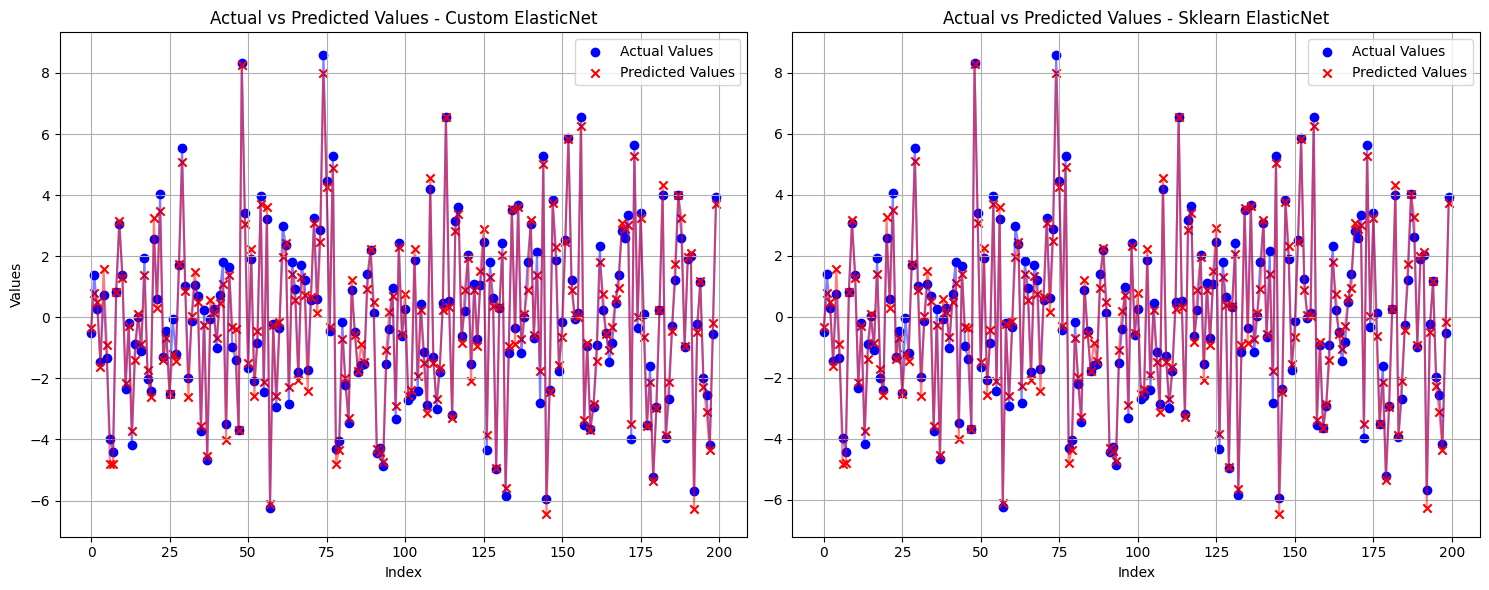

Custom Model MSE: 0.14815693888248077
Custom Model MAE: 0.31090431686292846
Custom Model R² Score: 0.9808019625757901

Sklearn Model MSE: 0.14856702500634344
Sklearn Model MAE: 0.3097388329726194
Sklearn Model R² Score: 0.9807488239998149



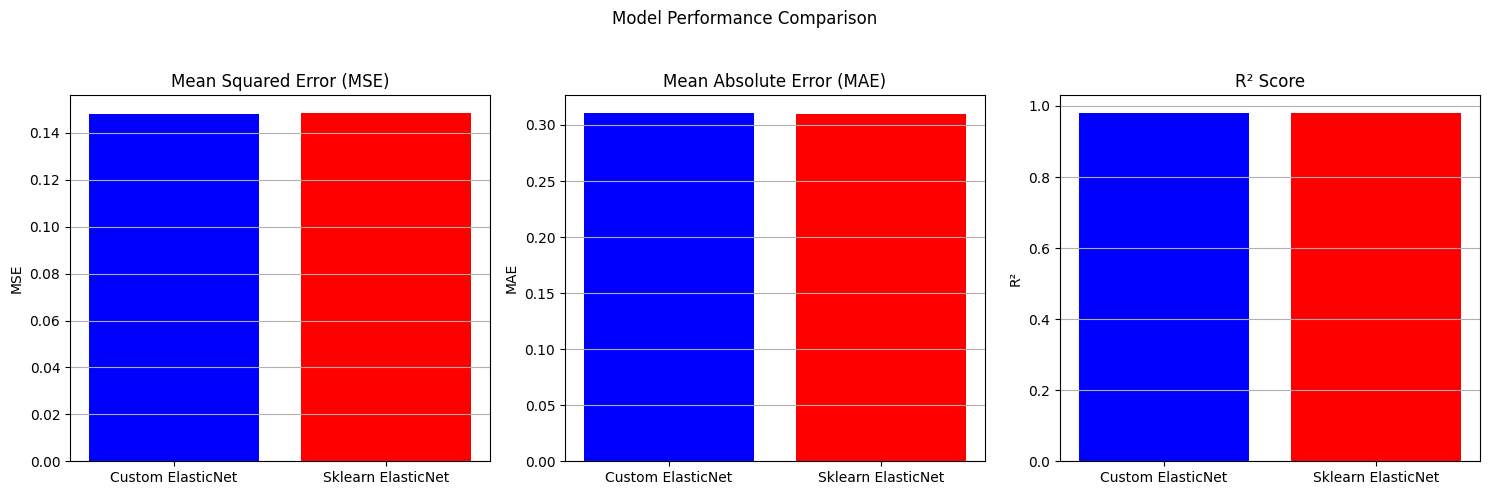

In [270]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(gen_comparison_df.index, gen_comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[0].scatter(gen_comparison_df.index, gen_comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[0].plot(gen_comparison_df.index, gen_comparison_df['Actual Values'], color='blue', alpha=0.5)
axs[0].plot(gen_comparison_df.index, gen_comparison_df['Predicted Values'], color='red', alpha=0.5)
axs[0].set_title('Actual vs Predicted Values - Custom ElasticNet')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid()

axs[1].scatter(Skgen_comparison_df.index, Skgen_comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
axs[1].scatter(Skgen_comparison_df.index, Skgen_comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
axs[1].plot(Skgen_comparison_df.index, Skgen_comparison_df['Actual Values'], color='blue', alpha=0.5)
axs[1].plot(Skgen_comparison_df.index, Skgen_comparison_df['Predicted Values'], color='red', alpha=0.5)
axs[1].set_title('Actual vs Predicted Values - Sklearn ElasticNet')
axs[1].set_xlabel('Index')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

custom_mse = np.square(gen_comparison_df["difference"]).mean()
custom_mae = np.abs(gen_comparison_df['difference']).mean()
custom_r2 = gen_model.r2_score(gen_y_test.values, gen_y_pred)

sklearn_mse = np.square(Skgen_comparison_df["difference"]).mean()
sklearn_mae = np.abs(Skgen_comparison_df['difference']).mean()
sklearn_r2 = gen_model.r2_score(gen_y_test.values, Skgen_y_pred)

print(f"Custom Model MSE: {custom_mse}")
print(f"Custom Model MAE: {custom_mae}")
print(f"Custom Model R² Score: {custom_r2}\n")

print(f"Sklearn Model MSE: {sklearn_mse}")
print(f"Sklearn Model MAE: {sklearn_mae}")
print(f"Sklearn Model R² Score: {sklearn_r2}\n")

custom_values = [custom_mse, custom_mae, custom_r2]
sklearn_values = [sklearn_mse, sklearn_mae, sklearn_r2]
metric_labels = ['MSE', 'MAE', 'R²']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mse, sklearn_mse], color=['blue', 'red'])
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_ylabel('MSE')
axs[0].grid(axis='y')

axs[1].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_mae, sklearn_mae], color=['blue', 'red'])
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_ylabel('MAE')
axs[1].grid(axis='y')

axs[2].bar(['Custom ElasticNet', 'Sklearn ElasticNet'], [custom_r2, sklearn_r2], color=['blue', 'red'])
axs[2].set_title('R² Score')
axs[2].set_ylabel('R²')
axs[2].grid(axis='y')

fig.suptitle('Model Performance Comparison')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Using Professor Generated Code for our ElasticNet Model

In [161]:
m = [2, 3, 4]  
N = 1000  
b = 5  
rnge = [-10, 10]  
scale = 0.4  
random_seed = 10  

prof_X , prof_y = linear_data_generator(m , N , b , rnge, scale, random_seed)
prof_X.shape, prof_y.shape


((1000, 3), (1000,))

In [162]:
prof_X_train, prof_X_test, prof_y_train, prof_y_test = train_test_split(prof_X,prof_y, test_size=0.2)

prof_X_train.shape, prof_X_test.shape, prof_y_train.shape, prof_y_test.shape

((800, 3), (200, 3), (800,), (200,))

In [163]:
prof_X_train_std, prof_X_test_std = standardize(prof_X_train, prof_X_test)

prof_X_train_std.shape, prof_X_test_std.shape

((800, 3), (200, 3))

In [164]:
prof_X_train_std_np = prof_X_train_std.values if isinstance(prof_X_train_std, pd.DataFrame) else prof_X_train_std
prof_y_train_np = prof_y_train.values if isinstance(prof_y_train, pd.Series) else prof_y_train
prof_X_test_std_np = prof_X_test_std.values if isinstance(prof_X_test_std, pd.DataFrame) else prof_X_test_std
prof_y_test_np = prof_y_test.values if isinstance(prof_y_test, pd.Series) else prof_y_test

prof_model = ElasticNet(alpha = 0.01,
                   penalty_ratio = 0.1,
                   learning_rate =0.001,
                   iterations= 10000)

prof_model.fit(prof_X_train_std_np, prof_y_train_np)

In [168]:
prof_y_pred =  prof_model.predict(prof_X_test_std_np)

In [169]:
prof_comparison_df = pd.DataFrame({
        'Actual Values': prof_y_test_np,
        'Predicted Values': prof_y_pred
    })
prof_comparison_df.head(10)

,Actual Values,Predicted Values
0,-37.157370,-37.012952
1,-7.095545,-6.824828
2,-33.509920,-32.997699
3,-33.731234,-33.803093
4,9.647953,10.304906
5,-29.660664,-28.637527
6,-10.796470,-10.670653
7,-38.316583,-37.180289
8,32.686239,32.638959
9,-5.641596,-5.809375


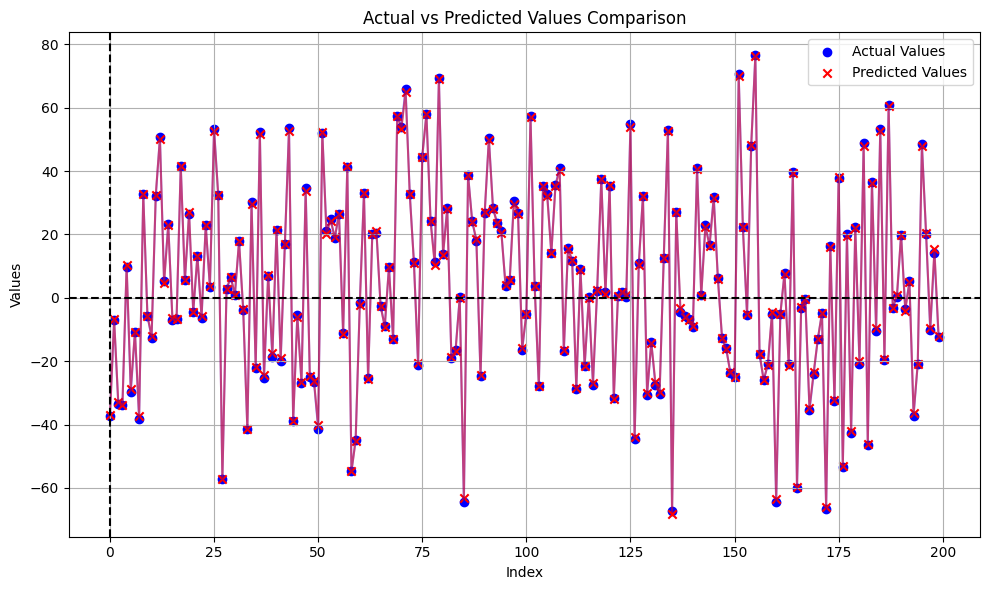

In [170]:
plt.figure(figsize=(10, 6))
plt.scatter(prof_comparison_df.index, prof_comparison_df['Actual Values'], color='blue', label='Actual Values', marker='o')
plt.scatter(prof_comparison_df.index, prof_comparison_df['Predicted Values'], color='red', label='Predicted Values', marker='x')
plt.plot(prof_comparison_df.index, prof_comparison_df['Actual Values'], color='blue', alpha=0.5)
plt.plot(prof_comparison_df.index, prof_comparison_df['Predicted Values'], color='red', alpha=0.5)

plt.title('Actual vs Predicted Values Comparison')
plt.xlabel('Index')
plt.ylabel('Values')
plt.axhline(0, color='black', linewidth=1.5, ls='--')
plt.axvline(0, color='black', linewidth=1.5, ls='--')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [171]:
prof_comparison_df["difference"] = prof_comparison_df['Actual Values'] - prof_comparison_df['Predicted Values']

prof_comparison_df.head(10)

,Actual Values,Predicted Values,difference
0,-37.157370,-37.012952,-0.144418
1,-7.095545,-6.824828,-0.270717
2,-33.509920,-32.997699,-0.512221
3,-33.731234,-33.803093,0.071859
4,9.647953,10.304906,-0.656953
5,-29.660664,-28.637527,-1.023137
6,-10.796470,-10.670653,-0.125817
7,-38.316583,-37.180289,-1.136295
8,32.686239,32.638959,0.047280
9,-5.641596,-5.809375,0.167779


In [172]:
mse = np.square(prof_comparison_df["difference"]).mean()

print(f"Mean Squared Error on Test Set : {mse}")

mae = np.abs(prof_comparison_df['difference']).mean()

print(f"Mean Absolute Error on Test Set : {mae}")

r2 = prof_model.r2_score(prof_y_test, prof_y_pred)
print(f"R² Score on Test Set : {r2}")

Mean Squared Error on Test Set : 0.2259325530808568
Mean Absolute Error on Test Set : 0.3724352649077815
R² Score on Test Set : 0.9997582135582405


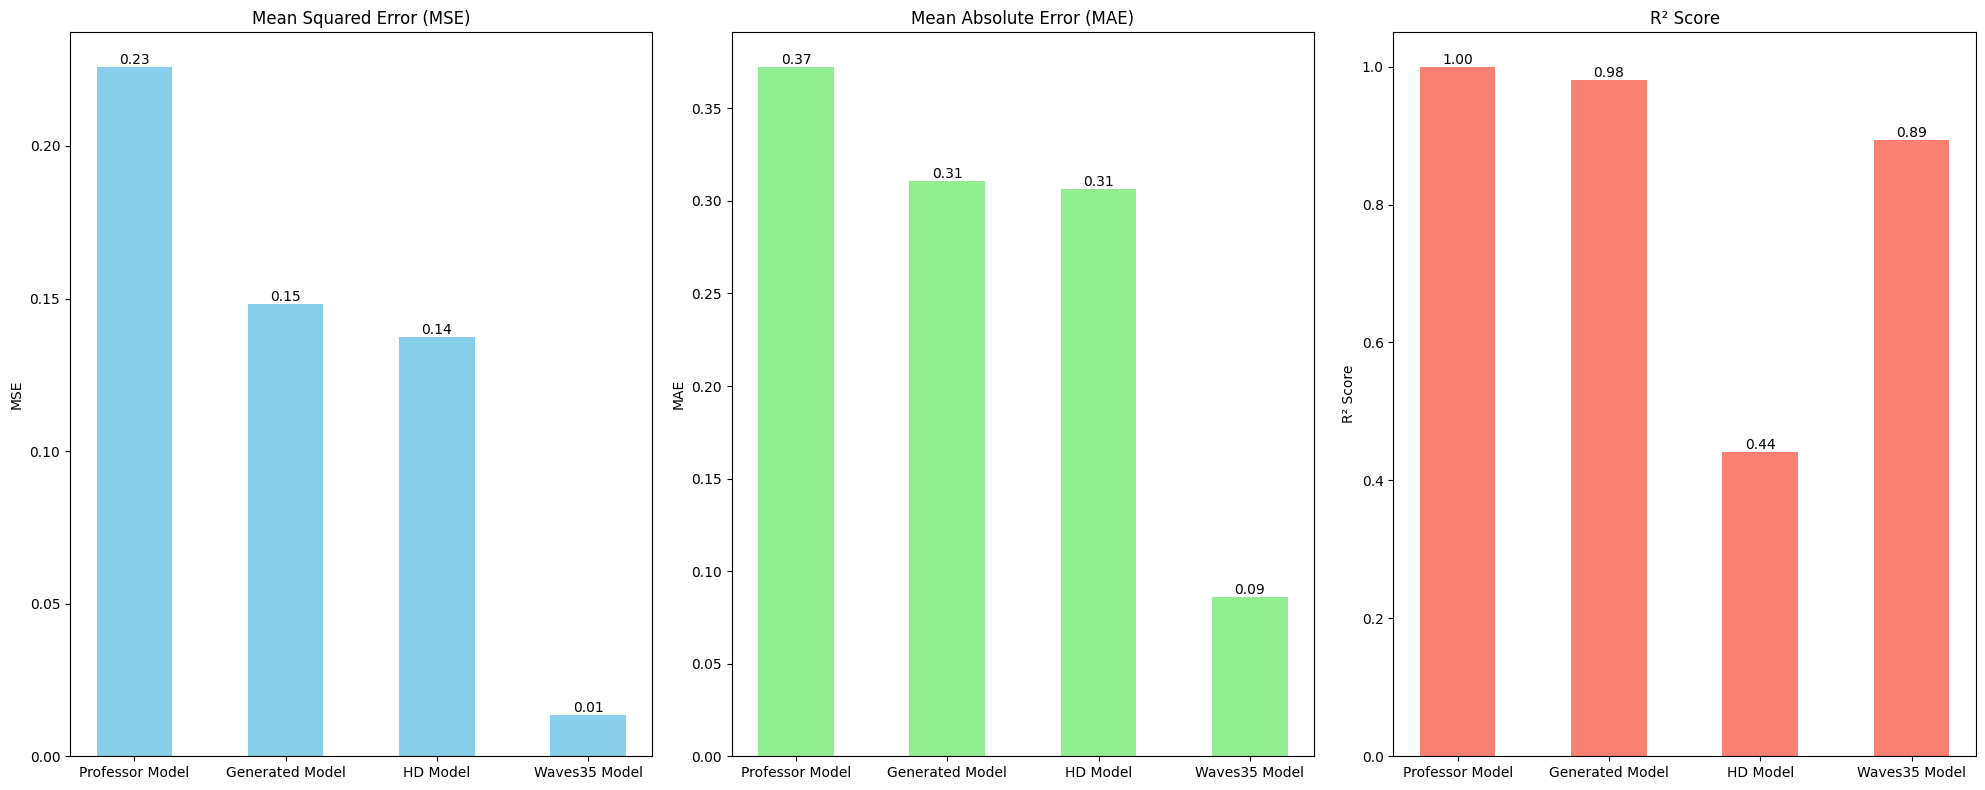

In [187]:
models = ['Professor Model', 'Generated Model', 'HD Model', 'Waves35 Model']
mse_values = [
    np.square(prof_comparison_df["difference"]).mean(),
    np.square(gen_comparison_df["difference"]).mean(),
    np.square(hd_comparison_df["difference"]).mean(),
    np.square(comparison_df["difference"]).mean()
]
mae_values = [
    np.abs(prof_comparison_df['difference']).mean(),
    np.abs(gen_comparison_df['difference']).mean(),
    np.abs(hd_comparison_df['difference']).mean(),
    np.abs(comparison_df['difference']).mean()
]
r2_scores = [
    prof_model.r2_score(prof_y_test, prof_y_pred),
    gen_model.r2_score(gen_y_test.values, gen_y_pred),
    hd_model.r2_score(hd_y_test.values, hd_y_pred),
    waves35_model.r2_score(waves35_y_test.values, waves35_y_pred)
]


x = np.arange(len(models))
width = 0.5

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].bar(x, mse_values, color='skyblue', width=width)
axs[0].set_title('Mean Squared Error (MSE)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].set_ylabel('MSE')

axs[1].bar(x, mae_values, color='lightgreen', width=width)
axs[1].set_title('Mean Absolute Error (MAE)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].set_ylabel('MAE')

axs[2].bar(x, r2_scores, color='salmon', width=width)
axs[2].set_title('R² Score')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models)
axs[2].set_ylabel('R² Score')


def autolabel(ax, values):
    for i, value in enumerate(values):
        ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')

autolabel(axs[0], mse_values)
autolabel(axs[1], mae_values)
autolabel(axs[2], r2_scores)

plt.tight_layout()
plt.show()


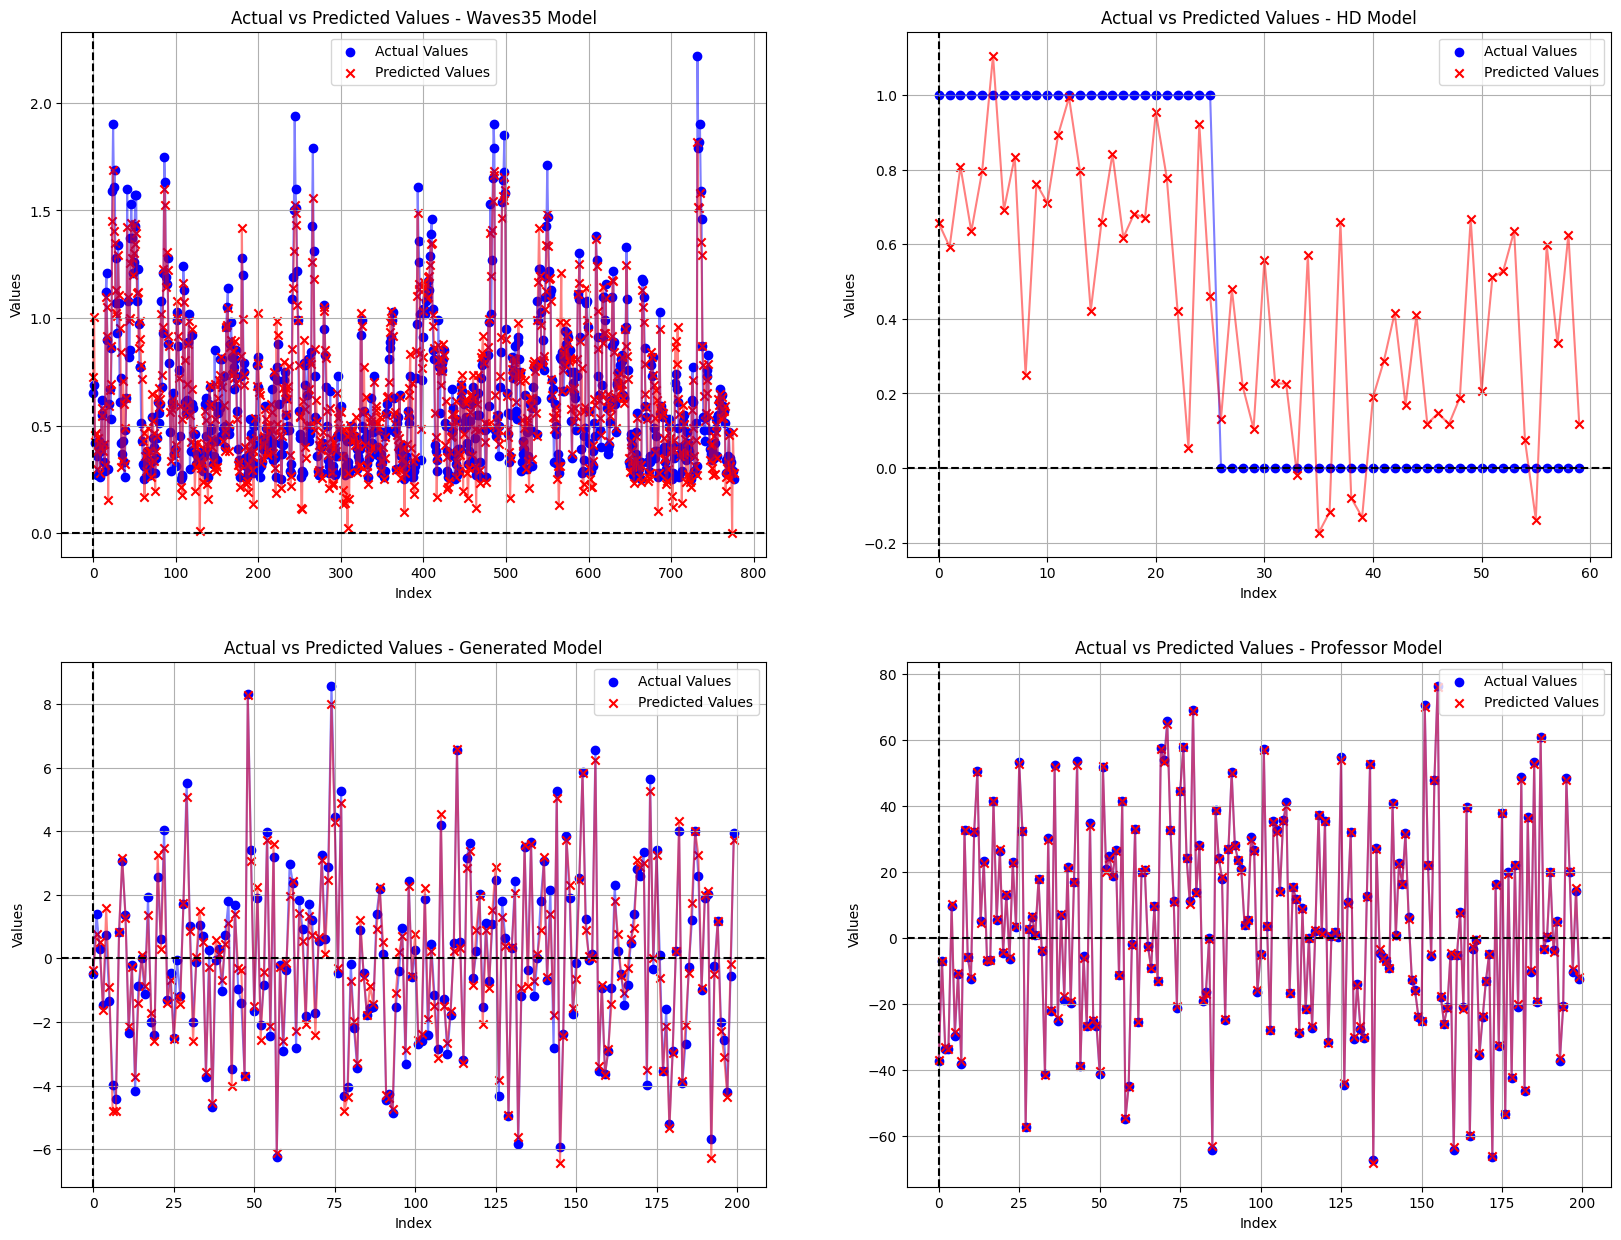

In [186]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

data_frames = [
    (comparison_df, 'Waves35 Model'),
    (hd_comparison_df, 'HD Model'),
    (gen_comparison_df, 'Generated Model'),
    (prof_comparison_df, 'Professor Model')
]
for i, (df, title) in enumerate(data_frames):
    row, col = divmod(i, 2) 
    axs[row, col].scatter(df.index, df['Actual Values'], color='blue', label='Actual Values', marker='o')
    axs[row, col].scatter(df.index, df['Predicted Values'], color='red', label='Predicted Values', marker='x')
    axs[row, col].plot(df.index, df['Actual Values'], color='blue', alpha=0.5)
    axs[row, col].plot(df.index, df['Predicted Values'], color='red', alpha=0.5)
    axs[row, col].set_title(f'Actual vs Predicted Values - {title}')
    axs[row, col].set_xlabel('Index')
    axs[row, col].set_ylabel('Values')
    axs[row, col].axhline(0, color='black', linewidth=1.5, ls='--')
    axs[row, col].axvline(0, color='black', linewidth=1.5, ls='--')
    axs[row, col].legend()
    axs[row, col].grid()

# plt.tight_layout()
plt.show()
